### **Pytorch一般有以下几个流程**


- 1. 数据读取

- 2. 数据处理

- 3. 搭建网络

- 4. 模型训练

- 5. 模型上线

## 1. 数据读取
CIFAR-10 是由 Hinton 的学生 Alex Krizhevsky 和 Ilya Sutskever 整理的一个用于识别普适物体的小型数据集。一共包含 10 个类别的 RGB 彩色图 片：飞机（ arplane ）、汽车（ automobile ）、鸟类（ bird ）、猫（ cat ）、鹿（ deer ）、狗（ dog ）、蛙类（ frog ）、马（ horse ）、船（ ship ）和卡车（ truck ）。图片的尺寸为 32×32 ，数据集中一共有 50000 张训练圄片和 10000 张测试图片。 

与 MNIST 数据集中目比， CIFAR-10 具有以下不同点：

    • CIFAR-10 是 3 通道的彩色 RGB 图像，而 MNIST 是灰度图像。
    • CIFAR-10 的图片尺寸为 32×32， 而 MNIST 的图片尺寸为 28×28，比 MNIST 稍大。
    • 相比于手写字符， CIFAR-10 含有的是现实世界中真实的物体，不仅噪声很大，而且物体的比例、 特征都不尽相同，这为识别带来很大困难。

首先使用`torchvision`加载和归一化我们的训练数据和测试数据。

    a、`torchvision`这个东西，实现了常用的一些深度学习的相关的图像数据的加载功能，比如cifar10、Imagenet、Mnist等等的，保存在`torchvision.datasets`模块中。
    
    b、同时，也封装了一些处理数据的方法。保存在`torchvision.transforms`模块中
    
    c、还封装了一些模型和工具封装在相应模型中,比如`torchvision.models`当中就包含了AlexNet，VGG，ResNet，SqueezeNet等模型。

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # 在指定GPU运行，比如第一个GPU就是0，如果多个GPU，就是"0,1"

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary

d:\miniconda3\envs\torch11\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**由于torchvision的datasets的输出是[0,1]的PILImage，所以我们先先归一化为[-1,1]的Tensor**

首先定义了一个变换transform，利用的是上面提到的transforms模块中的Compose( )把多个变换组合在一起，可以看到这里面组合了ToTensor和Normalize这两个变换

`transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`前面的（0.5，0.5，0.5） 是 R G B 三个通道上的均值， 后面(0.5, 0.5, 0.5)是三个通道的标准差，注意通道顺序是 R G B ，用过opencv的同学应该知道openCV读出来的图像是 BRG顺序。这两个tuple数据是用来对RGB 图像做归一化的，如其名称 Normalize 所示这里都取0.5只是一个近似的操作，实际上其均值和方差并不是这么多，但是就这个示例而言 影响可不计。精确值是通过分别计算R,G,B三个通道的数据算出来的。


In [2]:
transform = transforms.Compose([
#     transforms.CenterCrop(224),
    # transforms.RandomCrop(32,padding=4), # 数据增广
    # transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 

 `trainloader`其实是一个比较重要的东西，我们后面就是通过`trainloader`把数据传入网络，当然这里的`trainloader`其实是个变量名，可以随便取，重点是他是由后面的`torch.utils.data.DataLoader()`定义的，这个东西来源于`torch.utils.data`模块

In [3]:
Batch_Size = 128

In [4]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=2, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=2, drop_last=True)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## 2. 查看数据（格式，大小，形状）

In [5]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [7]:
trainset.data.shape #50000是图片数量，32x32是图片大小，3是通道数量RGB

(50000, 32, 32, 3)

In [8]:
#查看数据类型
print(type(trainset.data))
print(type(trainset))

<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>


### 总结：
    
    `trainset.data.shape`是标准的numpy.ndarray类型，其中50000是图片数量，32x32是图片大小，3是通道数量RGB；
    `trainset`是标准的？？类型，其中50000为图片数量，0表示取前面的数据，2表示3通道数RGB，32*32表示图片大小
    


 ## 3. 查看图片

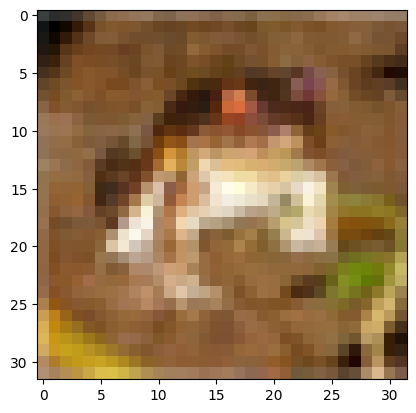

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0])
im,label = iter(trainloader).next()

### np.ndarray转为torch.Tensor

在深度学习中，原始图像需要转换为深度学习框架自定义的数据格式，在pytorch中，需要转为`torch.Tensor`。
pytorch提供了`torch.Tensor` 与`numpy.ndarray`转换为接口：

方法名|作用
--|--
`torch.from_numpy(xxx)`|`numpy.ndarray`转为torch.Tensor
`tensor1.numpy()`|获取tensor1对象的numpy格式数据

`torch.Tensor` 高维矩阵的表示： N x C x H x W

`numpy.ndarray` 高维矩阵的表示：N x H x W x C

因此在两者转换的时候需要使用`numpy.transpose( )` 方法 。


In [10]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

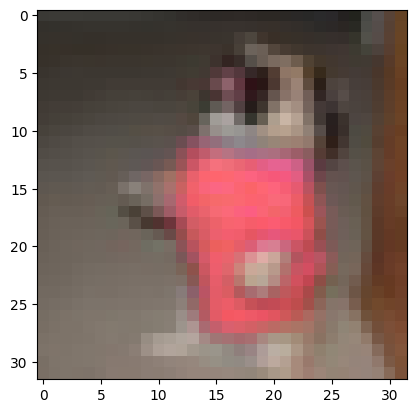

In [11]:
imshow(im[0])

In [12]:
im[0].shape

torch.Size([3, 32, 32])

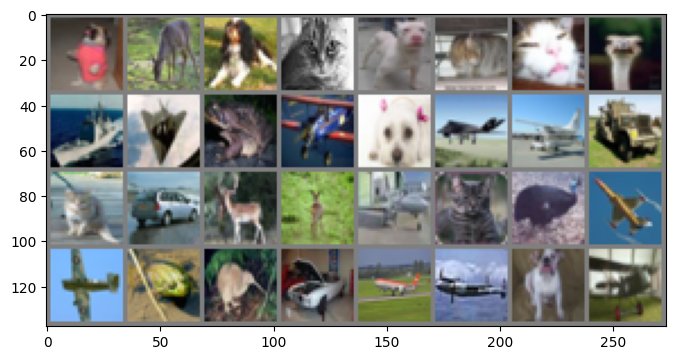

In [13]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))



## 4. 定义网络（ShuffleNetv2）

ShuffleNetv2是ECCV2018的文章，也是来源于旷视和清华研究组，它的效果同时是比ShuffleNetv1更好的。并且在同等复杂度下，ShuffleNetv2比ShuffleNet和MobileNetv2更准确。该论文最大的贡献在于看到了 GPU 访存带宽（内存访问代价 MAC）对于模型推理时间的影响，而不仅仅是模型复杂度，也就是 FLOPs 和参数量 Params 对于推理时间的影响，使用直接指标（如速度）而非间接指标（如FLOPs），并由此提出了 `4` 个轻量级网络设计的原则和一个新颖的 卷积 `block` 架构-`ShuffleNet v2`。

这个**网络的优势**在于：


**（1）** 作为轻量级的卷积神经网络，**ShuffleNetV2 相比其他轻量级模型速度稍快，准确率也更高**；

**（2）** 轻量级不仅体现在速度上，还**大大地减少了模型的参数量**，并且通过设定每个单元的通道数便可以灵活地调整模型的复杂度。



![在这里插入图片描述](https://img-blog.csdnimg.cn/direct/42b5531ca07648b19ba2a405785852c5.png)




浮点数运算量FLOPs被广泛用作计算复杂度的评估指标。然而，FLOPs是一项间接指标，无法与直接指标如速度和准确率等同。过往的工作也证明FLOPs相同的网络运算速度却不同。单一使用FLOPs作为评估指标可能导致次优方案。但在际运用中会发现，同一个FLOPS的网络运算速度却不同，只用FLOPS去进行衡量的话并不能完全代表模型速度。

直接指标与间接指标的矛盾可以归咎于两点原因。

1. FLOPs没有考虑影响速度的一些重要因素。例如内存访问成本，它在group convolution中占据大量运算时间，也是GPU运算时的潜在性能瓶颈，还有并行度。相同FLOPs的情况下，高度并行的网络执行起来会更加迅速。
2. FLOPs相同的操作，在不同平台下运行时不同。例如早期工作广泛使用张量分解来加速矩阵乘法。但是近期工作发现虽然它可以减少75%的FLOPs，但是在GPU上运算却更慢了。作者研究后发现这是因为最新的CUDNN（该文章发表于2018年）针对3×3卷积做了特殊优化。

通过如下图所示对比，作者发现Elemwise/Data IO等内存读写密集型操作也会极大的影响模型运算速度。

![读懂ShuffleNet V2](https://img-blog.csdnimg.cn/img_convert/fa41085c4766c6ec1413bddb08253a12.jpeg)



### 高效网络设计实用指南

作者在特定的平台下研究ShuffleNetv1和MobileNetv2的运行时间

- GPU。硬件为英伟达GTX 1080 Ti。软件CUDNN 7.0。
- ARM。硬件为高通Snapdragon 810。软件基于Neon高度优化的实现，测试时单线程。

同时根据结合理论与实验得到了4条实用的指导原则，先总结一下，作者认为高效的网络设计应当：

1. 同等通道大小最小化内存访问量
2. 过量使用组卷积会增加MAC
3. 网络碎片化会降低并行度
4. 不能忽略元素级操作的负面影响

#### 指南一：同等通道大小最小化内存访问量

在使用depthwise separable convolutions的网络中，pointwise卷积承担了大部分复杂度。输入通道数 $c1$ 与输出通道数$c2$决定了网络形状。特征图的高度与宽度为 h 与 w，则1×1卷积的FLOPs为 $B=hwc_1c_2$。

假设缓存足够大能够储存下完整的特征图及参数。内存访问成本可以记为$MAC=hw(c_1+c_2)+c_1c_2$，根据均值不等式可得：
$$
MAC >= 2\sqrt{hwB} + \frac{B}{hw}
$$
可见MAC的下界由FLOPs决定。当输入与输出通道相等时值最小。

这个结论是理论上的。实际的设备缓存通常不够大。现代运算库通常使用复杂的阻挡策略来最大化缓存的使用。为验证该指南，作者在测试网络中堆叠了10个block，每个block包含2个卷积层。第一个输入通道c1，输出通道c2；第二个则反过来。实验结果如下表，当c1:c2接近1:1时，MAC最小。

![img](https://img-blog.csdnimg.cn/img_convert/afd3495647a4d60dd4f625242b79cf45.jpeg)

#### 指南二：过量使用组卷积会增加MAC

分组卷积将稠密的卷积连接离散化，降低了FLOPs，使得使用更多的卷积通道成为可能。但是，这种操作增加了内存访问成本。

同指南一，1×1卷积的MAC公式可以记为：
$$
MAC=hw(c_1+c_2)+\frac{c_1c_2}{g}=hwc_1 + \frac{Bg}{c_1} + \frac{B}{hw}
$$
其中$g$为分组的数量， $B=hwc_1c_2/g$ 为FLOPs。可见，当 $g$ 增大时，MAC增大。

作者的实验显示，相比标准卷积，分组数为8的卷积运算耗时在GPU上增加了一倍，在ARM上增加了30%。因此分组卷积带来的准确率上升是以速度为代价的，需要谨慎设计。

![img](https://img-blog.csdnimg.cn/img_convert/f77313ae16ddd49c92007f18f89ac2b9.jpeg)

#### 指南三：网络碎片化会降低并行度

碎片化运算使用多个较小的运算取代单个较大的运算。尽管这样可以提升准确率，但是却降低了网络的并行度。这尤其不利于强并行运算资源如GPU，还会带来额外的kernel载入与同步损耗。

![img](https://img-blog.csdnimg.cn/img_convert/9641f59549794a2c7d8bfcac68312bda.jpeg)

为了量化碎片化带来的影响，作者设计了上图所示block。实验中，GPU下采用图c的网络比采用图a的慢3倍。在ARM下的影响则有限。

#### 指南四：不能忽略元素级操作的负面影响

逐元素操作包括ReLu、AddTensor、AddBias等。他们的FLOPs相对较小，但是内存访问成本却很高。（作者将depthwise convolution也看做逐元素操作）。试验中，去除ReLU与shortcut连接的ResNet在GPU和ARM上的速度都提升了20%。

### ShuffleNetv2的高效架构

ShuffleNet V1使用了pointwise group convolution以及类bottleneck结构，还引入了channel shuffle操作来促进不同群组间的信息交换。从上述的四个指南出发，作者提出了改进的ShuffleNet V2。

![img](https://img-blog.csdnimg.cn/img_convert/db1de5ceab1f4d3fd54b436b2029cfa5.jpeg)



在ShuffleNetv1的模块中，大量使用了1x1组卷积，这违背了**G2**原则

![在这里插入图片描述](https://img-blog.csdnimg.cn/direct/a8c7efa08eb049b5ae847b48197abc2f.png)


另外v1采用了类似ResNet中的瓶颈层（bottleneck layer），输入和输出通道数不同，这违背了**G1**原则。同时使用过多的组，也违背了**G3**原则。

![在这里插入图片描述](https://img-blog.csdnimg.cn/direct/982cb9719e304f7d9919db65e52ef4f7.png)


短路连接中存在大量的元素级Add运算，这违背了**G4**原则。

![在这里插入图片描述](https://img-blog.csdnimg.cn/direct/0b2b132193884d2aacf2e7c98495a098.png)

### 通道切分 channel split

为了改善v1的缺陷，v2版本引入了一种新的运算：channel split。

卷积块分为基本模块（左图）和下采样模块（右图），操作如下图(c)所示。在每个单元前输入通道c被划分为c-c'与c'两个分支。为避免碎片化，一个分支保持不变；另一个分支遵循指南一，包含3个恒等通道数的卷积层，且1×1卷积不再分组。之后两个分支拼接为一个，通道数不变；再执行通道随机化操作。对于具备降采样功能的单元如图(d)所示，去掉了通道切分后，输出通道数扩增一倍。

图(c) **Channel Spilt** 模块将输入图像的通道数平均分成两份，一份用于残差连接，一份用于特征提取。

图(d) **Channel Shuffle** 模块将堆叠的特征图的通道重新排序，实现各分组之间的特征融合。

在基本模块中，特征图size不变，通道数不变。在下采样模块中，特征图的长宽减半，通道数加倍。

在这种网络设计中，左边分支做同等映射，右边的分支包含3个连续的卷积，并且输入和输出通道相同，这符合**G1**。而且两个1x1卷积不再是组卷积，这符合**G2**，另外两个分支相当于已经分成两组。两个分支的输出不再是Add元素，而是concat在一起，紧接着是对两个分支concat结果进行channle shuffle，以保证两个分支信息交流。其实concat和channel shuffle可以和下一个模块单元的channel split合成一个元素级运算，这符合原则**G4**。

![在这里插入图片描述](https://img-blog.csdnimg.cn/direct/b06f3454ef8847be9e4e1b0924012aa7.png)

### ShuffleNetv2 网络结构

ShuffleNet V2就是基于以上两种单元构建的。为了简化操作，模型的c'=c/2。网络整体架构类似ShuffleNet V1，具体参数如下表所示。有一点不同之处是**在global averaged pooling前增加了1×1卷积以融合特征**。每个单元的channel数是可变的，以便统一缩放改变网络的复杂度。



![ShuffleNet v2 | PyTorch](https://img-blog.csdnimg.cn/img_convert/d289420d1d4f9adae126cb524573ce39.png)

#### 判断是否使用GPU

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

第一步我们需要构建我们的ShuffleBlock，这一部分其实是跟v1一样的，里面就用到了我们的核心理念，Channel Shuffle，其实在程序上实现channel shuffle是非常容易的：

假定将输入层分为 g 组，总通道数为 $g×n$ ，首先你将通道那个维度拆分为 $(g,n)$ 两个维度，然后将这两个维度转置变成 $(n,g)$ ，最后重新 reshape 成一个维度。如果你不太理解这个操作，你可以试着动手去试一下，发现仅需要简单的维度操作和转置就可以实现均匀的shuffle。利用channel shuffle就可以充分发挥group convolution的优点，而避免其缺点。

In [15]:
class ShuffleBlock(nn.Module):
    def __init__(self, groups=2):
        super(ShuffleBlock, self).__init__()
        self.groups = groups

    def forward(self, x):
        '''Channel shuffle: [N,C,H,W] -> [N,g,C/g,H,W] -> [N,C/g,g,H,w] -> [N,C,H,W]'''
        N,C,H,W = x.size()
        g = self.groups
        return x.view(N,g,C//g,H,W).permute(0,2,1,3,4).reshape(N,C,H,W)

还有就是上述提到的通道切分模块，也是比较容易实现的

In [16]:
class SplitBlock(nn.Module):
    def __init__(self, ratio):
        super(SplitBlock, self).__init__()
        self.ratio = ratio

    def forward(self, x):
        c = int(x.size(1) * self.ratio)
        return x[:, :c, :, :], x[:, c:, :, :]

然后先设计一个基础的模块，后续可以进行复用方便

In [17]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, split_ratio=0.5):
        super(BasicBlock, self).__init__()
        self.split = SplitBlock(split_ratio)
        in_channels = int(in_channels * split_ratio)
        self.conv1 = nn.Conv2d(in_channels, in_channels,
                               kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels,
                               kernel_size=3, stride=1, padding=1, groups=in_channels, bias=False)
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.conv3 = nn.Conv2d(in_channels, in_channels,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(in_channels)
        self.shuffle = ShuffleBlock()

    def forward(self, x):
        x1, x2 = self.split(x)
        out = F.relu(self.bn1(self.conv1(x2)))
        out = self.bn2(self.conv2(out))
        out = F.relu(self.bn3(self.conv3(out)))
        out = torch.cat([x1, out], 1)
        out = self.shuffle(out)
        return out


然后我们再设计我们的下采样的模块，对于下采样模块，不再有channel split，而是每个分支都是直接copy一份输入，每个分支都有stride=2的下采样，最后concat在一起后，特征图空间大小减半，但是通道数翻倍。

In [18]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        mid_channels = out_channels // 2
        # left
        self.conv1 = nn.Conv2d(in_channels, in_channels,
                               kernel_size=3, stride=2, padding=1, groups=in_channels, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, mid_channels,
                               kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        # right
        self.conv3 = nn.Conv2d(in_channels, mid_channels,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(mid_channels)
        self.conv4 = nn.Conv2d(mid_channels, mid_channels,
                               kernel_size=3, stride=2, padding=1, groups=mid_channels, bias=False)
        self.bn4 = nn.BatchNorm2d(mid_channels)
        self.conv5 = nn.Conv2d(mid_channels, mid_channels,
                               kernel_size=1, bias=False)
        self.bn5 = nn.BatchNorm2d(mid_channels)

        self.shuffle = ShuffleBlock()

    def forward(self, x):
        # left
        out1 = self.bn1(self.conv1(x))
        out1 = F.relu(self.bn2(self.conv2(out1)))
        # right
        out2 = F.relu(self.bn3(self.conv3(x)))
        out2 = self.bn4(self.conv4(out2))
        out2 = F.relu(self.bn5(self.conv5(out2)))
        # concat
        out = torch.cat([out1, out2], 1)
        out = self.shuffle(out)
        return out


基于网络结构表，我们就可以定义我们的ShuffleNetv2了，基本与ShuffleNetv1相同，这里优于shape不同，所以用的池化卷积也稍微有一点不同，用了4x4的，跟ShuffleNet一样

In [19]:
class ShuffleNetV2(nn.Module):
    def __init__(self, net_size, num_classes = 10):
        super(ShuffleNetV2, self).__init__()
        out_channels = configs[net_size]['out_channels']
        num_blocks = configs[net_size]['num_blocks']

        self.conv1 = nn.Conv2d(3, 24, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(24)
        self.in_channels = 24
        self.layer1 = self._make_layer(out_channels[0], num_blocks[0])
        self.layer2 = self._make_layer(out_channels[1], num_blocks[1])
        self.layer3 = self._make_layer(out_channels[2], num_blocks[2])
        self.conv2 = nn.Conv2d(out_channels[2], out_channels[3],
                               kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels[3])
        self.linear = nn.Linear(out_channels[3], num_classes)

    def _make_layer(self, out_channels, num_blocks):
        layers = [DownBlock(self.in_channels, out_channels)]
        for i in range(num_blocks):
            layers.append(BasicBlock(out_channels))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        # out = F.max_pool2d(out, 3, stride=2, padding=1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
# 根据表中的定义
configs = {
    0.5: {
        'out_channels': (48, 96, 192, 1024),
        'num_blocks': (3, 7, 3)
    },

    1: {
        'out_channels': (116, 232, 464, 1024),
        'num_blocks': (3, 7, 3)
    },
    1.5: {
        'out_channels': (176, 352, 704, 1024),
        'num_blocks': (3, 7, 3)
    },
    2: {
        'out_channels': (224, 488, 976, 2048),
        'num_blocks': (3, 7, 3)
    }
}

In [20]:
net = ShuffleNetV2(net_size=0.5).to(device)

### summary查看网络

我们可以通过summary来看到，模型的维度的变化，这个也是和论文是匹配的，经过层后shape的变化，是否最后也是输出(batch,shape)

In [21]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             648
       BatchNorm2d-2           [-1, 24, 32, 32]              48
            Conv2d-3           [-1, 24, 16, 16]             216
       BatchNorm2d-4           [-1, 24, 16, 16]              48
            Conv2d-5           [-1, 24, 16, 16]             576
       BatchNorm2d-6           [-1, 24, 16, 16]              48
            Conv2d-7           [-1, 24, 32, 32]             576
       BatchNorm2d-8           [-1, 24, 32, 32]              48
            Conv2d-9           [-1, 24, 16, 16]             216
      BatchNorm2d-10           [-1, 24, 16, 16]              48
           Conv2d-11           [-1, 24, 16, 16]             576
      BatchNorm2d-12           [-1, 24, 16, 16]              48
     ShuffleBlock-13           [-1, 48, 16, 16]               0
        DownBlock-14           [-1, 48,

首先从我们summary可以看到，我们输入的是（batch，3，32，32）的张量，并且这里也能看到每一层后我们的图像输出大小的变化，最后输出10个参数，再通过softmax函数就可以得到我们每个类别的概率了。

我们也可以打印出我们的模型观察一下

In [22]:
print(net)

ShuffleNetV2(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): DownBlock(
      (conv1): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
      (bn4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv5): Conv2d(24, 24, k

### 测试和定义网络

接下来可以简单测试一下，是否输入后能得到我们的正确的维度shape

In [23]:
test_x = torch.randn(2,3,32,32).to(device)
test_y = net(test_x)
print(test_y.shape)

torch.Size([2, 10])


定义网络和设置类别

In [24]:
net = ShuffleNetV2(net_size=0.5, num_classes=10)

## 5. 定义损失函数和优化器 

pytorch将深度学习中常用的优化方法全部封装在torch.optim之中，所有的优化方法都是继承基类optim.Optimizier
损失函数是封装在神经网络工具箱nn中的,包含很多损失函数


如果想更加了解优化器和学习率策略的话，可以参考以下资料

- [Pytorch Note15 优化算法1 梯度下降（Gradient descent varients）](https://blog.csdn.net/weixin_45508265/article/details/117859824)
- [Pytorch Note16 优化算法2 动量法(Momentum)](https://blog.csdn.net/weixin_45508265/article/details/117874046)
- [Pytorch Note34 学习率衰减](https://blog.csdn.net/weixin_45508265/article/details/119089705)

这里决定迭代10次

In [25]:
import torch.optim as optim
# optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), lr=1e-1)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.94 ,patience = 1,min_lr = 0.000001) # 动态更新学习率
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 1)
import time
epoch = 20

## 6. 训练及可视化（增加TensorBoard可视化）

In [21]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('文件已存在')
save_path = './model/ShuffleNetv2.pth'

文件已存在


这次更新了tensorboard的可视化，可以得到更好看的图片，并且能可视化出不错的结果

In [27]:
# 使用tensorboard
from torch.utils.tensorboard import SummaryWriter
os.makedirs("./logs", exist_ok=True)
tbwriter = SummaryWriter(log_dir='./logs/ShuffleNetv2', comment='ShuffleNetv2')  # 使用tensorboard记录中间输出
tbwriter.add_graph(model= net, input_to_model=torch.randn(size=(1, 3, 32, 32)))

/tmp/ipykernel_185506/3329330290.py:10: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return x.view(N,g,C//g,H,W).permute(0,2,1,3,4).reshape(N,C,H,W)
/tmp/ipykernel_185506/4127942637.py:7: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  c = int(x.size(1) * self.ratio)


如果存在GPU可以选择使用GPU进行运行，并且可以设置并行运算

In [28]:
if device == 'cuda':
    net.to(device)
    net = nn.DataParallel(net) # 使用并行运算
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

In [29]:
from utils import plot_history
from utils import train
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, tbwriter, verbose = True)

Test Epoch 1/20: 100%|██████████| 78/78 [00:01<00:00, 51.88it/s, Test Acc=0.32, Test Loss=1.81] 


Epoch [  1/ 20]  Train Loss:2.181060  Train Acc:20.16% Test Loss:1.812469  Test Acc:32.01%  Learning Rate:0.100000


Test Epoch 2/20: 100%|██████████| 78/78 [00:01<00:00, 55.32it/s, Test Acc=0.454, Test Loss=1.48]


Epoch [  2/ 20]  Train Loss:1.558131  Train Acc:39.95% Test Loss:1.481740  Test Acc:45.44%  Learning Rate:0.100000


Test Epoch 3/20: 100%|██████████| 78/78 [00:01<00:00, 53.75it/s, Test Acc=0.474, Test Loss=1.44]


Epoch [  3/ 20]  Train Loss:1.375844  Train Acc:48.95% Test Loss:1.436291  Test Acc:47.38%  Learning Rate:0.100000


Test Epoch 4/20: 100%|██████████| 78/78 [00:01<00:00, 52.70it/s, Test Acc=0.511, Test Loss=1.39]


Epoch [  4/ 20]  Train Loss:1.249782  Train Acc:54.56% Test Loss:1.389962  Test Acc:51.11%  Learning Rate:0.100000


Test Epoch 5/20: 100%|██████████| 78/78 [00:01<00:00, 56.07it/s, Test Acc=0.572, Test Loss=1.21]


Epoch [  5/ 20]  Train Loss:1.168995  Train Acc:58.10% Test Loss:1.210948  Test Acc:57.17%  Learning Rate:0.100000


Test Epoch 6/20: 100%|██████████| 78/78 [00:01<00:00, 51.49it/s, Test Acc=0.57, Test Loss=1.2]  


Epoch [  6/ 20]  Train Loss:1.109439  Train Acc:60.02% Test Loss:1.204134  Test Acc:57.04%  Learning Rate:0.100000


Test Epoch 7/20: 100%|██████████| 78/78 [00:01<00:00, 55.05it/s, Test Acc=0.608, Test Loss=1.15]


Epoch [  7/ 20]  Train Loss:1.057093  Train Acc:62.45% Test Loss:1.154943  Test Acc:60.77%  Learning Rate:0.100000


Test Epoch 8/20: 100%|██████████| 78/78 [00:01<00:00, 56.74it/s, Test Acc=0.612, Test Loss=1.11]


Epoch [  8/ 20]  Train Loss:1.024675  Train Acc:63.65% Test Loss:1.113078  Test Acc:61.22%  Learning Rate:0.100000


Test Epoch 9/20: 100%|██████████| 78/78 [00:01<00:00, 54.63it/s, Test Acc=0.614, Test Loss=1.14]


Epoch [  9/ 20]  Train Loss:0.986667  Train Acc:65.11% Test Loss:1.142446  Test Acc:61.44%  Learning Rate:0.100000


Test Epoch 10/20: 100%|██████████| 78/78 [00:01<00:00, 57.09it/s, Test Acc=0.652, Test Loss=15.3]


Epoch [ 10/ 20]  Train Loss:0.953566  Train Acc:66.32% Test Loss:15.277926  Test Acc:65.19%  Learning Rate:0.100000


Test Epoch 11/20: 100%|██████████| 78/78 [00:01<00:00, 57.69it/s, Test Acc=0.614, Test Loss=1.28]


Epoch [ 11/ 20]  Train Loss:0.921855  Train Acc:67.84% Test Loss:1.284624  Test Acc:61.44%  Learning Rate:0.100000


Test Epoch 12/20: 100%|██████████| 78/78 [00:01<00:00, 59.13it/s, Test Acc=0.667, Test Loss=1.01] 


Epoch [ 12/ 20]  Train Loss:0.881344  Train Acc:68.95% Test Loss:1.005071  Test Acc:66.70%  Learning Rate:0.100000


Test Epoch 13/20: 100%|██████████| 78/78 [00:01<00:00, 52.73it/s, Test Acc=0.661, Test Loss=0.996]


Epoch [ 13/ 20]  Train Loss:0.858123  Train Acc:70.07% Test Loss:0.996488  Test Acc:66.10%  Learning Rate:0.100000


Test Epoch 14/20: 100%|██████████| 78/78 [00:01<00:00, 54.49it/s, Test Acc=0.711, Test Loss=0.855]


Epoch [ 14/ 20]  Train Loss:0.830285  Train Acc:71.23% Test Loss:0.855183  Test Acc:71.07%  Learning Rate:0.100000


Test Epoch 15/20: 100%|██████████| 78/78 [00:01<00:00, 55.80it/s, Test Acc=0.664, Test Loss=260]  


Epoch [ 15/ 20]  Train Loss:0.799097  Train Acc:72.67% Test Loss:260.248212  Test Acc:66.43%  Learning Rate:0.100000


Test Epoch 16/20: 100%|██████████| 78/78 [00:01<00:00, 53.76it/s, Test Acc=0.699, Test Loss=116]  


Epoch [ 16/ 20]  Train Loss:0.780266  Train Acc:73.08% Test Loss:115.791749  Test Acc:69.94%  Learning Rate:0.100000


Test Epoch 17/20: 100%|██████████| 78/78 [00:01<00:00, 56.72it/s, Test Acc=0.724, Test Loss=3.52] 


Epoch [ 17/ 20]  Train Loss:0.747231  Train Acc:74.64% Test Loss:3.520048  Test Acc:72.45%  Learning Rate:0.100000


Test Epoch 18/20: 100%|██████████| 78/78 [00:01<00:00, 53.87it/s, Test Acc=0.725, Test Loss=0.845]


Epoch [ 18/ 20]  Train Loss:0.708474  Train Acc:75.88% Test Loss:0.845017  Test Acc:72.53%  Learning Rate:0.100000


Test Epoch 19/20: 100%|██████████| 78/78 [00:01<00:00, 55.64it/s, Test Acc=0.722, Test Loss=1.83e+5]


Epoch [ 19/ 20]  Train Loss:0.671686  Train Acc:77.30% Test Loss:183250.281071  Test Acc:72.23%  Learning Rate:0.100000


Test Epoch 20/20: 100%|██████████| 78/78 [00:01<00:00, 56.07it/s, Test Acc=0.721, Test Loss=0.861]

Epoch [ 20/ 20]  Train Loss:0.644469  Train Acc:78.11% Test Loss:0.860960  Test Acc:72.06%  Learning Rate:0.100000


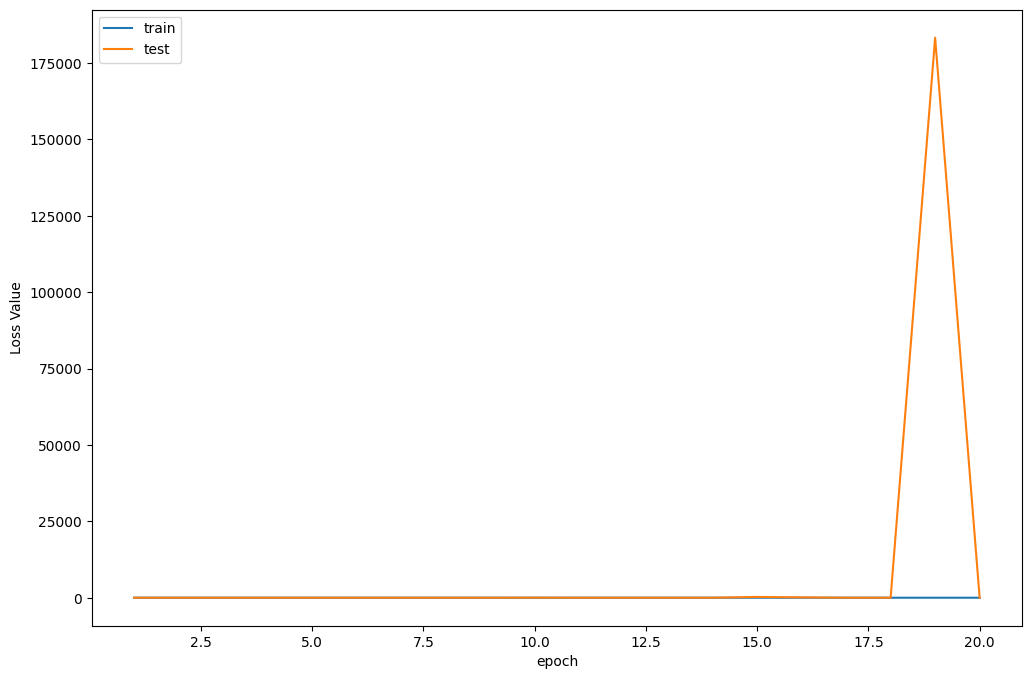

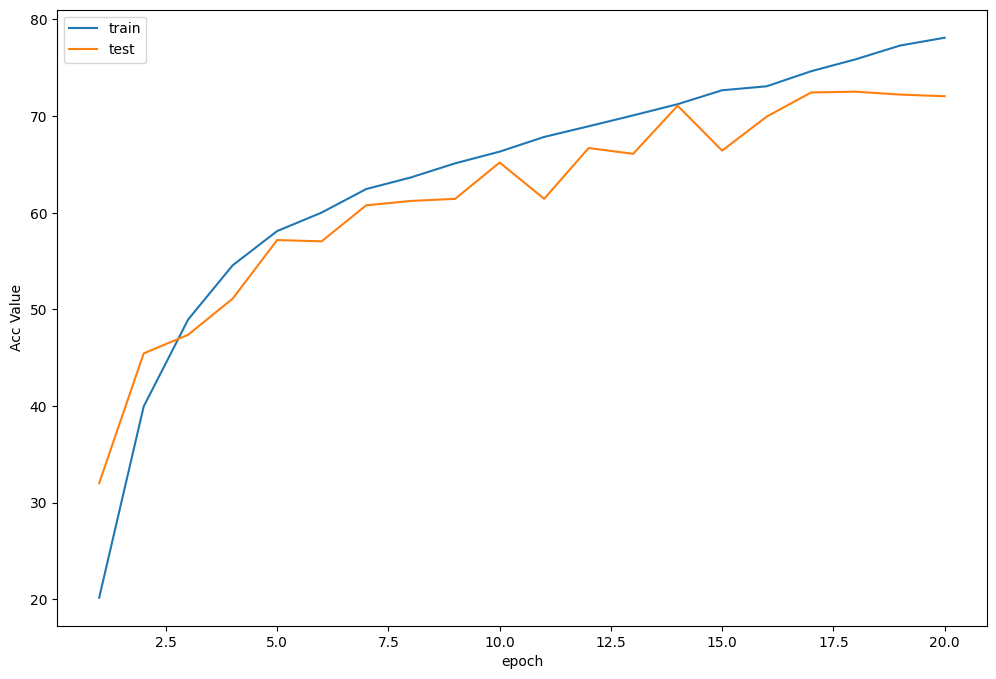

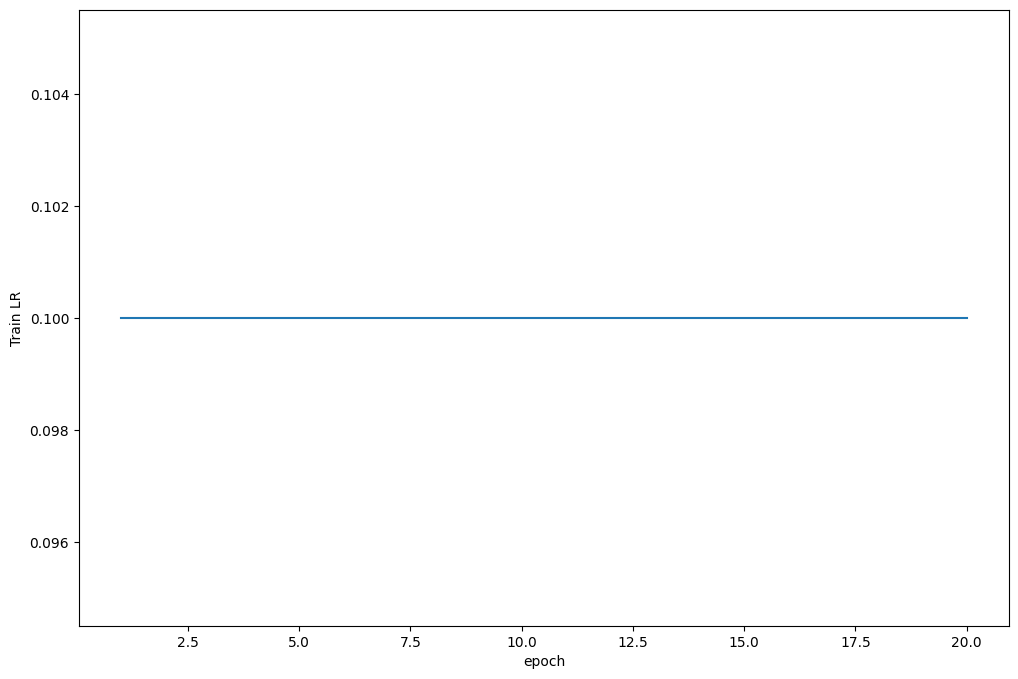

In [30]:
plot_history(epoch ,Acc, Loss, Lr)

In [31]:
# # 查看tensorboard
# %reload_ext tensorboard
# %tensorboard --logdir './log'

## 7. 测试

In [32]:
correct = 0   # 定义预测正确的图片数，初始化为0
total = 0     # 总共参与测试的图片数，也初始化为0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
for data in testloader:  # 循环每一个batch
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    net.eval()  # 把模型转为test模式
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
    outputs = net(images)  # 输入网络进行测试
    
    # outputs.data是一个4x10张量，将每一行的最大的那一列的值和序号各自组成一个一维张量返回，第一个是值的张量，第二个是序号的张量。
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)          # 更新测试图片的数量
    correct += (predicted == labels).sum() # 更新正确分类的图片的数量

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))
 

Accuracy of the network on the 10000 test images: 72.06 %


程序中的 `torch.max(outputs.data, 1)` ，返回一个tuple (元组)

而这里很明显，这个返回的元组的第一个元素是image data，即是最大的 值，第二个元素是label， 即是最大的值 的 索引！我们只需要label（最大值的索引），所以就会有` _ `,predicted这样的赋值语句，表示忽略第一个返回值，把它赋值给` _`， 就是舍弃它的意思；

In [33]:
 # 定义2个存储每类中测试正确的个数的 列表，初始化为0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
    #4组(batch_size)数据中，输出于label相同的，标记为1，否则为0
        c = (predicted == labels).squeeze()
        for i in range(len(images)):      # 因为每个batch都有4张图片，所以还需要一个4的小循环
            label = labels[i]   # 对各个类的进行各自累加
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 74.12 %
Accuracy of automobile : 89.19 %
Accuracy of  bird : 58.43 %
Accuracy of   cat : 74.20 %
Accuracy of  deer : 61.20 %
Accuracy of   dog : 49.75 %
Accuracy of  frog : 57.70 %
Accuracy of horse : 73.70 %
Accuracy of  ship : 90.09 %
Accuracy of truck : 92.18 %


Accuracy Rate = 72.65625%


<Figure size 2500x400 with 0 Axes>

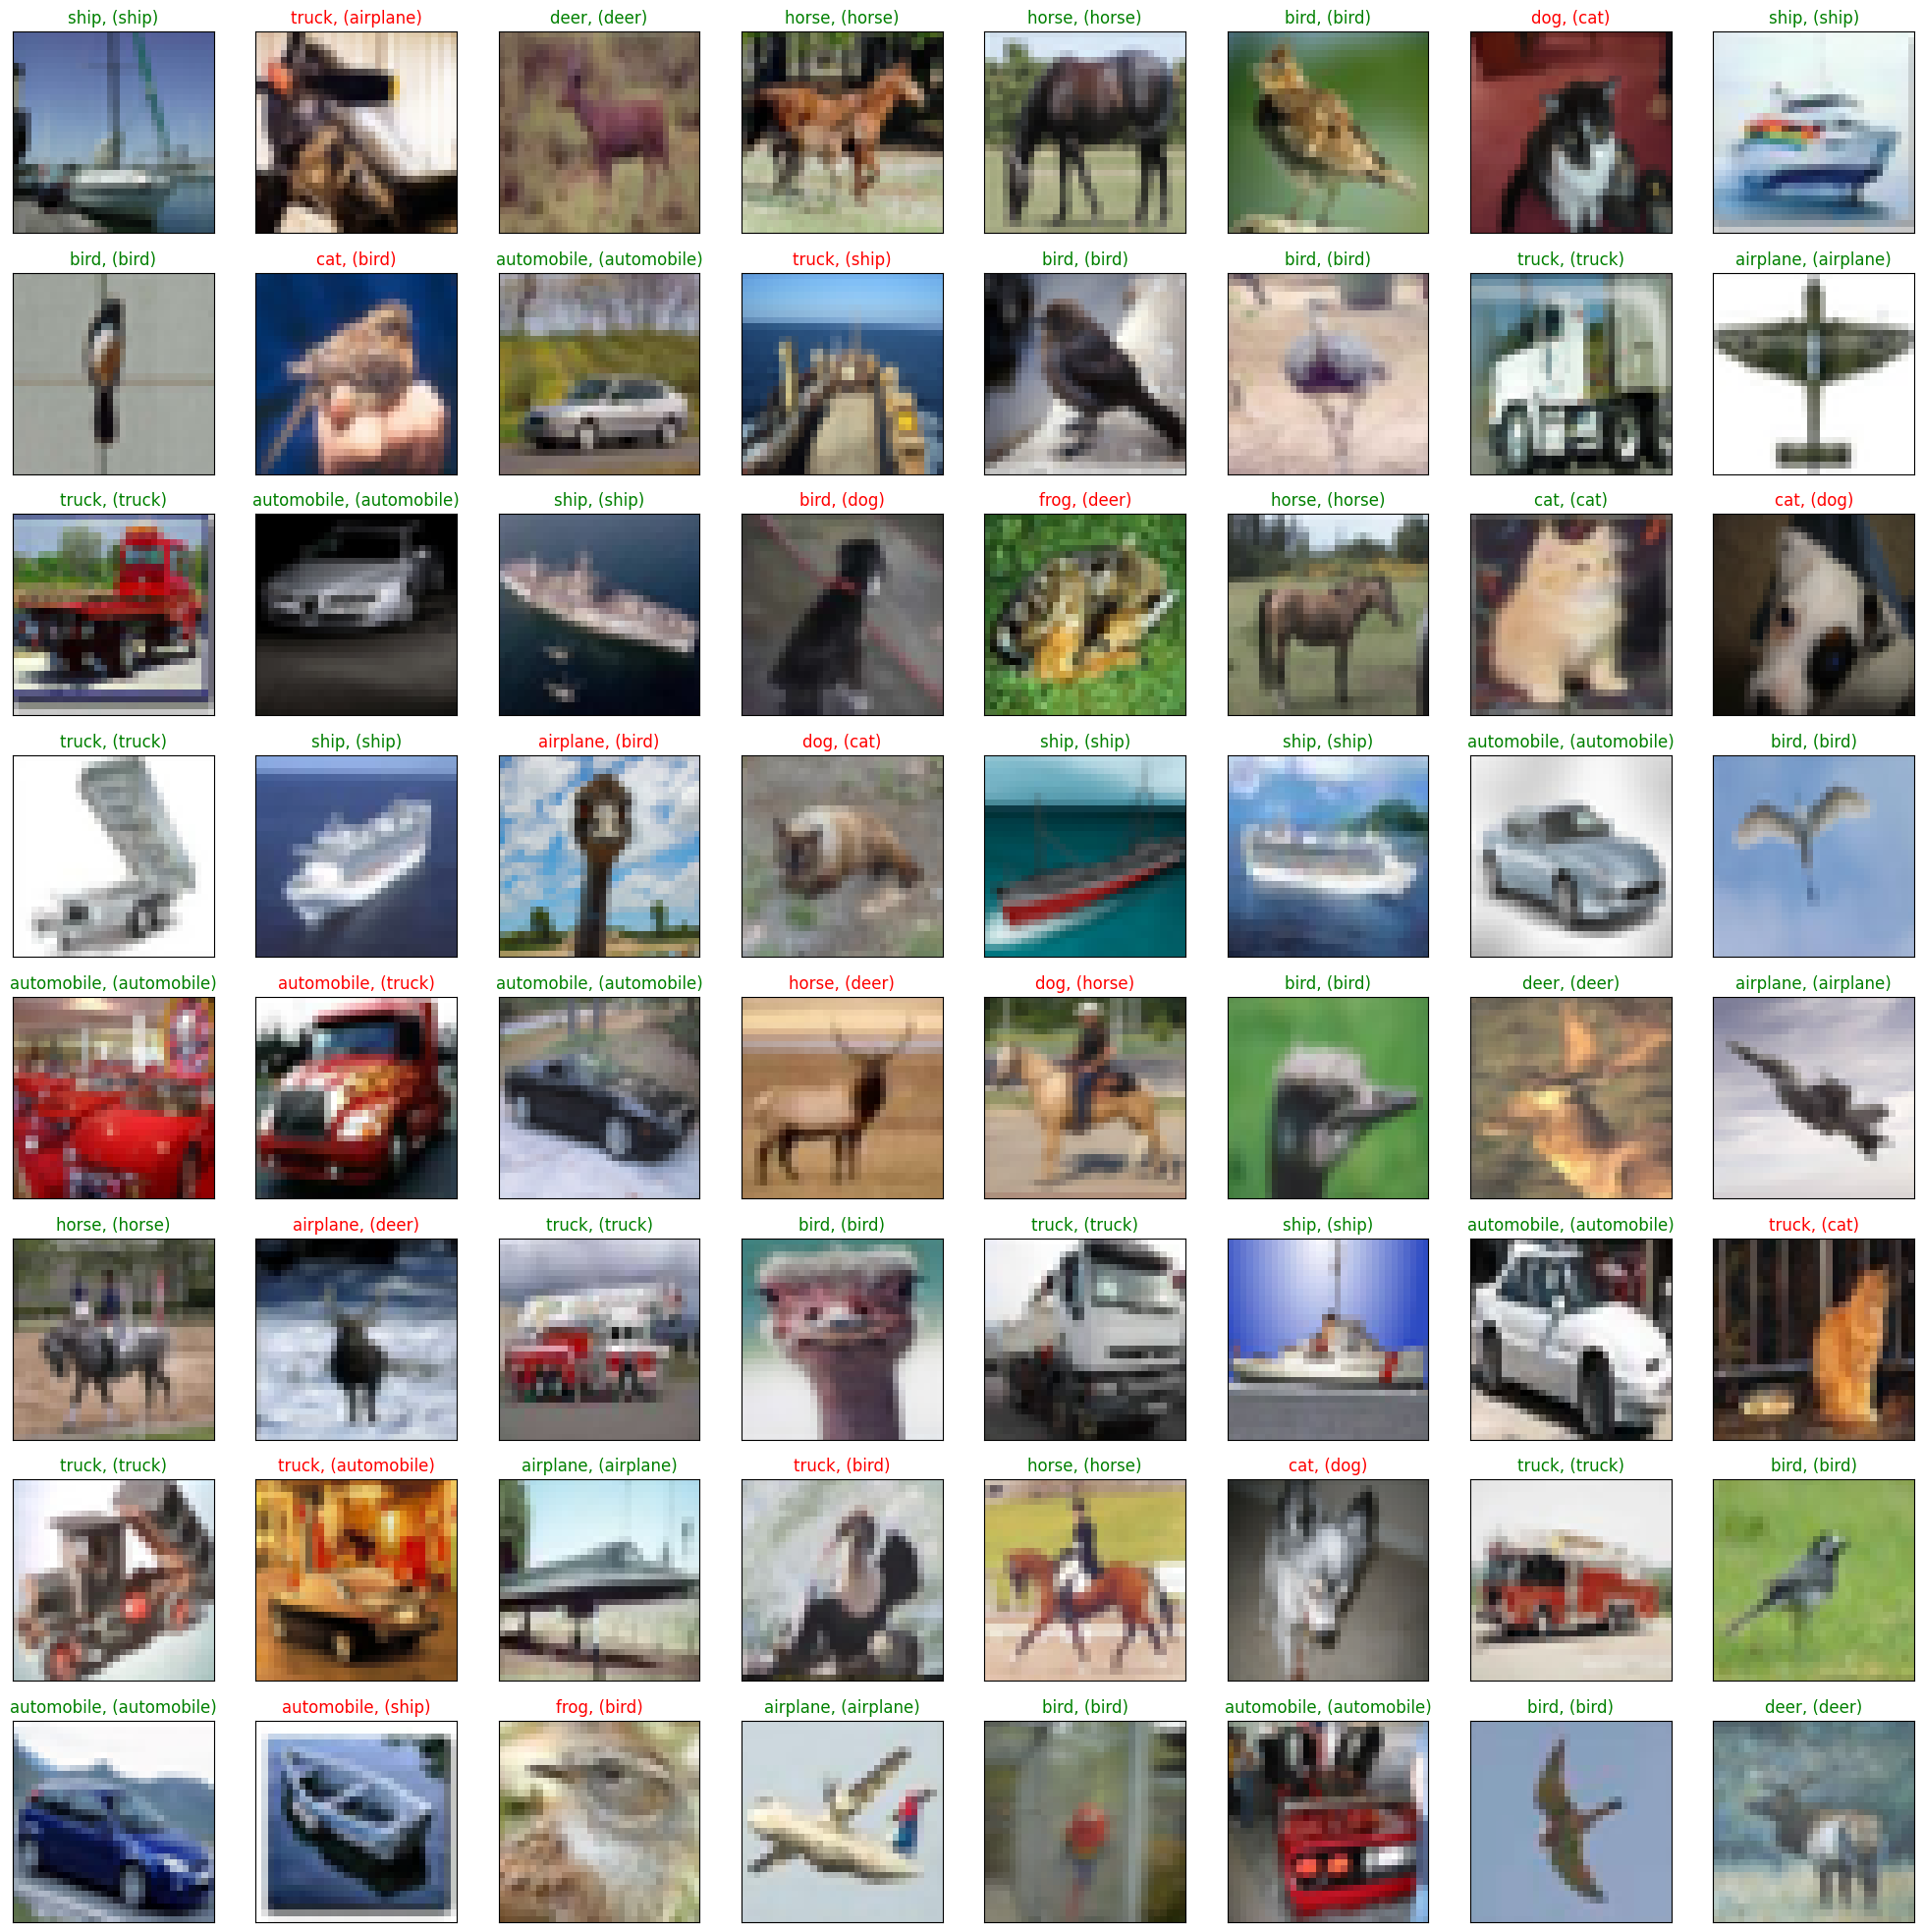

In [34]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(64):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
#     plt.imshow(im_convert(images[idx]))
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

## 8. 保存模型

In [35]:
torch.save(net,save_path[:-4]+'_'+str(epoch)+'.pth')

## 9. 预测

In [22]:
import torch
from PIL import Image
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ShuffleNetV2(net_size = 0.5 ,num_classes=10)

model = torch.load(save_path)  # 加载模型
# model = model.to('cuda')
model.eval()  # 把模型转为test模式

# 读取要预测的图片
img = Image.open("./airplane.jpg").convert('RGB') # 读取图像

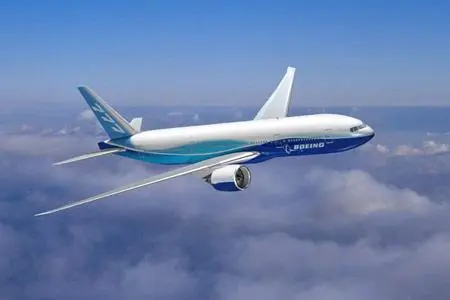

In [23]:
img

In [24]:
trans = transforms.Compose([transforms.Resize((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

概率 tensor([[9.6835e-01, 3.9865e-03, 7.3552e-03, 9.4701e-05, 5.8011e-04, 3.3870e-06,
         3.0435e-04, 3.3818e-05, 1.9139e-02, 1.5286e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
类别 0
tensor([7.0582], device='cuda:0')
分类 plane


<Response [200]>


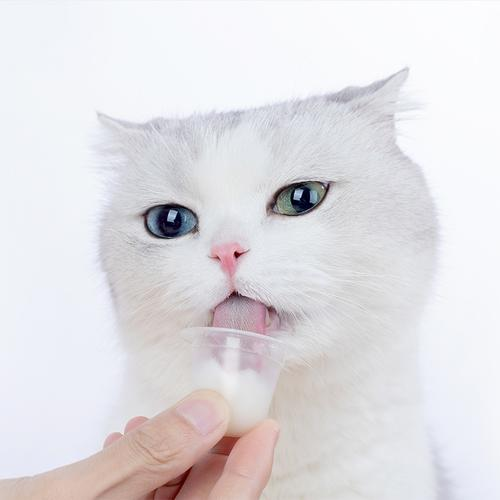

In [33]:
import requests
from PIL import Image
url = 'https://dss2.bdstatic.com/70cFvnSh_Q1YnxGkpoWK1HF6hhy/it/u=947072664,3925280208&fm=26&gp=0.jpg'
# url = 'https://ss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=2952045457,215279295&fm=26&gp=0.jpg'
# url = 'https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=2838383012,1815030248&fm=26&gp=0.jpg'
# url = 'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fwww.goupuzi.com%2Fnewatt%2FMon_1809%2F1_179223_7463b117c8a2c76.jpg&refer=http%3A%2F%2Fwww.goupuzi.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1624346733&t=36ba18326a1e010737f530976201326d'
url = 'https://ss3.bdstatic.com/70cFv8Sh_Q1YnxGkpoWK1HF6hhy/it/u=2799543344,3604342295&fm=224&gp=0.jpg'
# url = 'https://ss1.bdstatic.com/70cFuXSh_Q1YnxGkpoWK1HF6hhy/it/u=2032505694,2851387785&fm=26&gp=0.jpg'
response = requests.get(url, stream=True)
print (response)
img = Image.open(response.raw)
img

In [34]:
trans = transforms.Compose([transforms.Resize((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

概率 tensor([[0.2931, 0.0125, 0.5008, 0.0560, 0.0500, 0.0200, 0.0140, 0.0412, 0.0107,
         0.0017]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
类别 2
tensor([1.3903], device='cuda:0')
分类 bird
